# What is semantic search?

https://en.wikipedia.org/wiki/Semantic_search

>  Semantic search seeks to improve search accuracy by understanding the searcher's intent and the contextual meaning of terms as they appear in the searchable dataspace,

# How to achieve this?

If you have enough resources or you are in a very specific problem domain, use ontologies

## What are ontologies

Short read about ontologies:
 
https://www.ontotext.com/knowledgehub/fundamentals/what-are-ontologies/

this image is taken from SWSN course
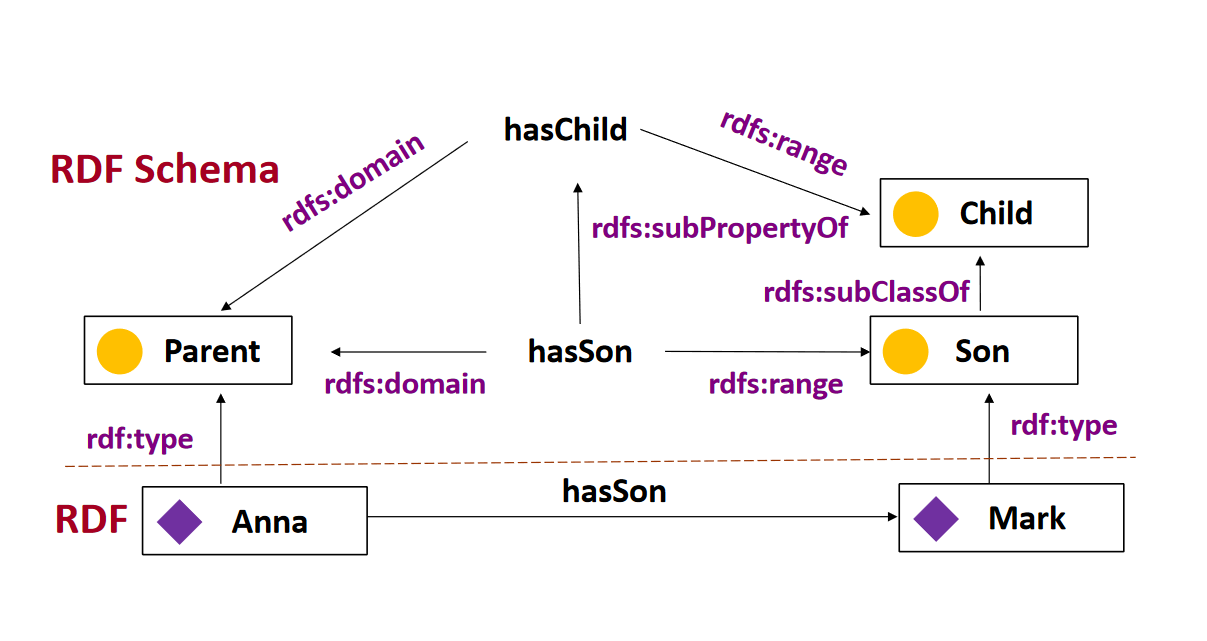

ontology = formal specification of concepts from some domain

## Issues with ontologies

- hard to formalize, each relation between objects need to be named, what if we don't have an accurate description of that relation?
- need experts
- need to learn how to query them
- (in most cases) they don't allow for imprecision, knowledge in ontologies is either true or untrue

## Searching over vast amounts of data

Creating a good, precise ontology for every bit of text, such that it is searchable for unforeseen questions is hard.

Instead we use methods like:

- [TF-IDF](https://medium.com/analytics-vidhya/an-introduction-to-tf-idf-using-python-5f9d1a343f77)
- [Rule based matching](https://spacy.io/usage/rule-based-matching) in short parsing natural language for entities to understand the intent of user
- [Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) e.g. Google, use information on what users clicked to provide better filtering


## Semantic search with embeddings

Here embeddings come to help, having qualities similar to the methods I've shown above.

### What are embeddings?

A really good introduction into the concept: https://www.featureform.com/post/the-definitive-guide-to-embeddings

- embeddings encode synonyms close to each other in vector space
- because cosine similarity returns a floating point value, they allow for imprecision
- they are straightforward to use 

## How to use embeddings

A good introductory notebook, I recommend to download and click through: https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/retrieve_rerank/retrieve_rerank_simple_wikipedia.ipynb

### Retrieve and rerank

https://www.sbert.net/examples/applications/retrieve_rerank/README.html

In short, **cross-encoder** models because of their architecture, are much better at ranking passages than bi-encoder or other embedding models.

But they are not efficient, they need both query and passage to be passed for embedding to be calculated for every passage and query pair. Unless we know questions before hand this is inefficient.

Hence why we use bi-encoders which need just the passage. Then the calculated embedding can be stored in a DB that enables techniques like HNSW for efficient retrieval of similar embeddings.

### Which models to use?

Here is a leaderboard, unfortunately there are not a lot of models in general that support Polish

https://huggingface.co/spaces/mteb/leaderboard

For this task, use these models:

https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=trending

Internal states of neural networks are also called embeddings, however these are not necessarily trained to work with cosine similarity!

# Semantic search with fastembed

https://github.com/qdrant/fastembed

- uses quantized models which is great if we deal with a lot of data

In [ ]:
%pip install fastembed --quiet 
%pip install pypdf2 --quiet 
%pip install nltk --quiet 
%pip install pprint --quiet 

In [11]:
import requests

url = 'https://commission.europa.eu/document/download/d2ec4039-c5be-423a-81ef-b9e44e79825b_en?filename=commission-white-paper-artificial-intelligence-feb2020_en.pdf'
response = requests.get(url)

with open('commission-white-paper-artificial-intelligence-feb2020_en.pdf', 'wb') as f:
    f.write(response.content)


In [14]:
# pypdf
import PyPDF2

pdfFileObj = open('commission-white-paper-artificial-intelligence-feb2020_en.pdf', 'rb')

pdfReader = PyPDF2.PdfReader(pdfFileObj)

print(pdfReader.pages)

In [18]:
pages = [page.extract_text() for page in pdfReader.pages]

In [24]:
from nltk import sent_tokenize
from pprint import pprint

In [27]:
# create passages of length max 512 characters
passages = []

for page in pages:
    # split page into sentences
    sentences = sent_tokenize(page)

    # create passages
    passage = ""
    for sentence in sentences:
        if len(passage) + len(sentence) < 512:
            passage += sentence
        else:
            passages.append(passage)
            passage = sentence

    # add last passage
    passages.append(passage)

pprint(passages[0])
pprint(passages[1])
pprint(passages[2])

(' \n'
 'EN   EN \n'
 ' \n'
 ' \n'
 ' EUROPEAN  \n'
 'COMMISSION   \n'
 'Brussels, 19.2.2020  \n'
 'COM(2020) 65 final  \n'
 ' \n'
 'WHITE PAPER  \n'
 'On Artificial Intelligence - A European approach to excellence and trust')
(' \n'
 '1 \n'
 ' White Paper on Artificial Intelligence  \n'
 'A European approach  to excellence and trust  \n'
 'Artificial Intelligence  is developing fast .It will change  our lives by '
 'improving healthcare (e.g.')
('making \n'
 'diagnosis more precise, enabling better prevention of diseases) , increasing '
 'the efficiency of farming,  \n'
 'contributing to climate change  mitigation and adaptation , improving the '
 'efficiency of production \n'
 'system s through predictive maintenance, increasing the security of '
 'Europeans , and in many other ways \n'
 'that we can only begin to imagine.')


In [28]:
len(passages)

239

Even though we used sentence tokenizer, some sentences are split.

Either way some passages may not have full information because of our splits

To accomodate for that we will use sliding windows

In [38]:
# create passages of length max 512 characters
passages = []

for page in pages:
    # split page into sentences
    sentences = sent_tokenize(page)

    # create a sliding window of sentences
    for i in range(len(sentences)):
        passage = ""
        for sentence in sentences[i:]:
            if len(passage) + len(sentence) < 512:
                passage += sentence
            else:
                passages.append(passage)
                break

pprint(passages[0])
pprint(passages[1])
pprint(passages[2])
len(passages)
        

(' \n'
 '1 \n'
 ' White Paper on Artificial Intelligence  \n'
 'A European approach  to excellence and trust  \n'
 'Artificial Intelligence  is developing fast .It will change  our lives by '
 'improving healthcare (e.g.')
('It will change  our lives by improving healthcare (e.g.making \n'
 'diagnosis more precise, enabling better prevention of diseases) , increasing '
 'the efficiency of farming,  \n'
 'contributing to climate change  mitigation and adaptation , improving the '
 'efficiency of production \n'
 'system s through predictive maintenance, increasing the security of '
 'Europeans , and in many other ways \n'
 'that we can only begin to imagine.')
('making \n'
 'diagnosis more precise, enabling better prevention of diseases) , increasing '
 'the efficiency of farming,  \n'
 'contributing to climate change  mitigation and adaptation , improving the '
 'efficiency of production \n'
 'system s through predictive maintenance, increasing the security of '
 'Europeans , and in man

471

In practical use, you will have to decide if you want your results to be singular sentences or longer passages. Depending on your resource constraints

Keep in mind that embedding of a single sentence and a passage takes the same amount of space - the size of the vector does not change!

Now let's calculate embeddings

the following is adapted from https://qdrant.github.io/fastembed/examples/Retrieval_with_FastEmbed/#tip-prefer-using-query_embed-for-queries-and-passage_embed-for-documents

In [42]:
from fastembed.embedding import FlagEmbedding as Embedding
import numpy as np
from typing import List
# load model

embedding_model = Embedding(model_name="BAAI/bge-small-en", max_length=512)

In [43]:
# We'll use the passage_embed method to get the embeddings for the documents
embeddings: List[np.ndarray] = list(
    embedding_model.passage_embed(passages)
)  # notice that we are casting the generator to a list

print(embeddings[0].shape, len(embeddings))

(384,) 471


Notice that our embeddings are of size 384, this is relevant for vector stores

In [45]:
def print_top_k(query_embedding, embeddings, documents, k=5):
    # use numpy to calculate the cosine similarity between the query and the documents
    scores = np.dot(embeddings, query_embedding)
    # sort the scores in descending order
    sorted_scores = np.argsort(scores)[::-1]
    # print the top 5
    for i in range(k):
        print(f"Rank {i+1}: {documents[sorted_scores[i]]}")


query = "What is the Commission's approach to AI?"
query_embedding = list(embedding_model.query_embed(query))[0]

print_top_k(query_embedding, embeddings, passages)

Rank 1: The Commission is of the opinion that  a given AI application should generally be considered high -risk 
in light of what is at stake, considering whether both the sector and the intended  use involve 
significant risks , in particular from the viewpoint of protection of safety , con sumer rights  and 
fundamental rights .
Rank 2: The Commission is of the opinion that the legislative framework could be improved to address  the 
following risks and situations : 
 Effective application and enforcement of existing EU and national legislation : the key 
characteristics of AI create challenges for ensuring the proper application and enforcement of 
EU and national legislation.
Rank 3: Their development 
and functioning must be such to ensure that AI systems behave reliably as intended.All reasonable 
measures should be taken to minimise the risk of harm being caused.
Rank 4: Equally 
important is to creat e testing and experimentation  sites to support the development and subsequen

As you can see this opens up possibilities:
- if we added a mapping from passage to its position in a document we can move user straight to the relevant part
- use top outputs to pass into summarization models
- embeddings can also be used for clustering, finding duplicates within documents etc.